# Build the neural network for prediction of the price of 2025

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from keras import backend as K
import numpy as np

In [2]:
# Read the file
df1_2 = pd.read_csv("../data/curated/price_normalised3.csv")

In [3]:
df1_2

,Unnamed: 0,name,postcode,property_type,bedrooms,bathrooms,parking,schools,cost_text,train_station(m),CBD(m),population2022,population2023,population2024,population2025,income2022,income2023,income2024,income2025,price_label
0,5321,Room 6/8 Melwood Court Meadow Heights VIC 3048,3048,Apartment / Unit / Flat,1,1,0,0.3,130.000000,2131.1,19150.7,17364.0,16549.0,15773.0,15034.0,86498,88316,90176,92078,0
1,5569,30 Daly Boulevard Highton VIC 3216,3216,House,9,2,2,2.0,130.000000,2904.1,85109.1,59229.0,60753.0,62377.0,64109.0,184195,192855,201927,211432,0
2,640,62 Reserve Rd Grovedale VIC 3216,3216,House,1,2,2,1.0,140.000000,1809.3,87665.1,59229.0,60753.0,62377.0,64109.0,184195,192855,201927,211432,0
3,5570,1/57 Wanda Road Caulfield North VIC 3161,3161,House,1,1,0,0.6,140.000000,1432.7,9784.5,10418.0,10185.0,9957.0,9734.0,56454,58176,59951,61780,0
4,5571,Room 2/31 Stanley Street Frankston VIC 3199,3199,House,1,1,1,1.1,145.000000,916.1,53197.1,60500.0,59711.0,58932.0,58164.0,176387,182176,188161,194348,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6716,6157,3502/14-16 The Esplanade St Kilda VIC 3182,3182,Apartment / Unit / Flat,3,3,3,0.8,1153.846154,1923.6,7936.4,27813.0,26448.0,25151.0,23917.0,61492,63821,66238,68747,3
6717,6156,9 Lansdowne Street Blairgowrie VIC 3942,3942,House,3,2,3,3.3,1153.846154,43496.1,106670.1,2104.0,2128.0,2152.0,2177.0,44616,45495,46391,47305,3
6718,6155,901 & 902/85 Market Street South Melbourne VIC...,3205,Apartment / Unit / Flat,3,3,1,0.3,1384.615385,4576.3,30462.2,3182.0,3085.0,2990.0,2899.0,70585,72357,74173,76035,3
6719,6154,Upstairs 2C Staley Street Brunswick VIC 3056,3056,House,0,0,0,0.8,673.076923,590.8,5545.2,17310.0,16654.0,16022.0,15415.0,68842,72533,76422,80520,1


## Remove assumed outliers which may affect the performance of the model

### Assumer postcode areas which have less than 100 population and have less than average $1000 yearly income per person as outliers

In [4]:
outliers = []
for i in range(0, len(df1_2)):
    if i not in outliers:
        if df1_2['population2022'][i] < 100 or df1_2['income2022'][i] < 1000:
            outliers.append(i)

In [5]:
# number of such outliers
len(outliers)

39

In [6]:
# remove outliers
if len(outliers) > 0:
    df1_3 = df1_2.drop(df1_2.index[outliers])

In [7]:
df1_3 = df1_3.reset_index()

### Assume properties with 0 bedrooms as outliers

In [8]:
outliers2 = []
for i in range(0, len(df1_3)):
    if i not in outliers2:
        if df1_3['bedrooms'][i] == 0:
            outliers2.append(i)

In [9]:
# number of such outliers
len(outliers2)

76

In [10]:
# remove outliers
if len(outliers2) > 0:
    df1_4 = df1_3.drop(df1_3.index[outliers2])

## Start to build the model

### the final selected features include: property type, number of bedrooms, number of bathroom, number of parking spaces, the distance to the closest school(km), the distance to the nearest train station(m), the distance to CBD(m), the population of 2022 and the income of 2022

Some codes were referenced from https://towardsdatascience.com/deep-learning-with-python-neural-networks-complete-tutorial-6b53c0b06af0 and https://thinkingneuron.com/using-artificial-neural-networks-for-regression-in-python/#:~:text=Using%20Artificial%20Neural%20Networks%20for%20Regression%20in%20Python,set%20of%20parameters%20using%20manual%20grid%20search%20

In [11]:
df1 = df1_4[['property_type', 'bedrooms', 'bathrooms', 'parking','schools', 'cost_text', \
    'train_station(m)', 'CBD(m)', 'population2022', 'income2022']] #

In [12]:
# one-hot encoding for the categorical feature
df_dummy = pd.get_dummies(df1['property_type'], \
    prefix=['property_type'], drop_first=False, dummy_na=False)
df1_1 = pd.concat([df1, df_dummy], axis=1)
df1_1 = df1_1.drop(['property_type'], axis = 1)

In [13]:
df1_1

,bedrooms,bathrooms,parking,schools,cost_text,train_station(m),CBD(m),population2022,income2022,['property_type']_Acreage / Semi-Rural,...,['property_type']_House,['property_type']_New Apartments / Off the Plan,['property_type']_New House & Land,['property_type']_Penthouse,['property_type']_Rural,['property_type']_Semi-Detached,['property_type']_Studio,['property_type']_Terrace,['property_type']_Townhouse,['property_type']_Villa
0,1,1,0,0.3,130.000000,2131.1,19150.7,17364.0,86498,0,...,0,0,0,0,0,0,0,0,0,0
1,9,2,2,2.0,130.000000,2904.1,85109.1,59229.0,184195,0,...,1,0,0,0,0,0,0,0,0,0
2,1,2,2,1.0,140.000000,1809.3,87665.1,59229.0,184195,0,...,1,0,0,0,0,0,0,0,0,0
3,1,1,0,0.6,140.000000,1432.7,9784.5,10418.0,56454,0,...,1,0,0,0,0,0,0,0,0,0
4,1,1,1,1.1,145.000000,916.1,53197.1,60500.0,176387,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6676,3,2,4,1.4,1038.461538,358.8,1621.2,8538.0,82000,0,...,0,0,0,0,0,0,0,0,0,0
6677,3,3,3,0.8,1153.846154,1923.6,7936.4,27813.0,61492,0,...,0,0,0,0,0,0,0,0,0,0
6678,3,2,3,3.3,1153.846154,43496.1,106670.1,2104.0,44616,0,...,1,0,0,0,0,0,0,0,0,0
6679,3,3,1,0.3,1384.615385,4576.3,30462.2,3182.0,70585,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
X=df1_1.drop("cost_text", axis=1).values
y=df1_1[["cost_text"]].values

In [15]:
# use StandardScaler to standardise the data which can significantly improve the performance of the model
scaler = StandardScaler() 
# Generating the standardized values of X and y
X=scaler.fit_transform(X)
y=scaler.fit_transform(y)

In [16]:
# split the dataset to train and test datasets(used to test the performance of the model)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 

In [17]:
# define metrics
#!pip install keras
#!pip install --ignore-installed --upgrade tensorflow 
def R2(y, y_hat):
    ss_res = K.sum(K.square(y - y_hat)) 
    ss_tot = K.sum(K.square(y - K.mean(y))) 
    return ( 1 - ss_res/(ss_tot + K.epsilon()) )

2022-10-08 18:44:04.641917: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-08 18:44:07.658095: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-08 18:44:07.658274: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-08 18:44:07.817348: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-08 18:44:14.733595: W tensorflow/stream_executor/platform/de

In [19]:
# train and build the model using the training datasets
model = Sequential()
model.add(Dense(units=12, input_dim=22, kernel_initializer='normal', activation='relu'))
model.add(Dense(units=12, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=[R2])
model.fit(X_train, y_train ,batch_size = 64, epochs = 197, verbose=1)

2022-10-08 18:44:23.085338: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-08 18:44:23.086435: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-08 18:44:23.086542: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (HP-SPECTRE-Pro3): /proc/driver/nvidia/version does not exist
2022-10-08 18:44:23.090426: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/197
83/83 [==============================] - 4s 11ms/step - loss: 0.9883 - R2: 0.0210
Epoch 2/197
83/83 [==============================] - 1s 13ms/step - loss: 0.7114 - R2: 0.3033
Epoch 3/197
83/83 [==============================] - 1s 16ms/step - loss: 0.5772 - R2: 0.4344
Epoch 4/197
83/83 [==============================] - 1s 18ms/step - loss: 0.5409 - R2: 0.4633
Epoch 5/197
83/83 [==============================] - 1s 13ms/step - loss: 0.5194 - R2: 0.4776
Epoch 6/197
83/83 [==============================] - 1s 9ms/step - loss: 0.5016 - R2: 0.4973
Epoch 7/197
83/83 [==============================] - 1s 12ms/step - loss: 0.4875 - R2: 0.5201
Epoch 8/197
83/83 [==============================] - 1s 7ms/step - loss: 0.4770 - R2: 0.5337
Epoch 9/197
83/83 [==============================] - 1s 8ms/step - loss: 0.4696 - R2: 0.5354
Epoch 10/197
83/83 [==============================] - 1s 10ms/step - loss: 0.4641 - R2: 0.5389
Epoch 11/197
83/83 [==============================] - 1s 7ms/s

From the above output, the final value of MAE is ... and the final value of R2 is ... . That means that ...

In [20]:
n_features_true = 9
model_for_plot = Sequential(name="DeepNN", layers=[
    ### hidden layer 1
    Dense(name="h1", input_dim=n_features_true,
                 units=12, 
                 activation='relu'),

    Dense(name="h2", units=12, 
                 activation='relu'),
    
    ### layer output
    Dense(name="output", units=1, activation='linear')
])

In [21]:

# visualise the neural network
# codes here was referenced from https://towardsdatascience.com/deep-learning-with-python-neural-networks-complete-tutorial-6b53c0b06af0
def utils_nn_config(model):
    lst_layers = []
    if "Sequential" in str(model): #-> Sequential doesn't show the input layer
        layer = model.layers[0]
        lst_layers.append({"name":"input", "in":int(layer.input.shape[-1]), "neurons":0, 
                           "out":int(layer.input.shape[-1]), "activation":None,
                           "params":0, "bias":0})
    for layer in model.layers:
        try:
            dic_layer = {"name":layer.name, "in":int(layer.input.shape[-1]), "neurons":layer.units, 
                         "out":int(layer.output.shape[-1]), "activation":layer.get_config()["activation"],
                         "params":layer.get_weights()[0], "bias":layer.get_weights()[1]}
        except:
            dic_layer = {"name":layer.name, "in":int(layer.input.shape[-1]), "neurons":0, 
                         "out":int(layer.output.shape[-1]), "activation":None,
                         "params":0, "bias":0}
        lst_layers.append(dic_layer)
    return lst_layers



'''
Plot the structure of a keras neural network.
'''
def visualize_nn(model, description=False, figsize=(10,8)):
    ## get layers info
    lst_layers = utils_nn_config(model)
    layer_sizes = [layer["out"] for layer in lst_layers]
    
    ## fig setup
    fig = plt.figure(figsize=figsize)
    ax = fig.gca()
    ax.set(title=model.name)
    ax.axis('off')
    left, right, bottom, top = 0.1, 0.9, 0.1, 0.9
    x_space = (right-left) / float(len(layer_sizes)-1)
    y_space = (top-bottom) / float(max(layer_sizes))
    p = 0.025
    
    ## nodes
    for i,n in enumerate(layer_sizes):
        top_on_layer = y_space*(n-1)/2.0 + (top+bottom)/2.0
        layer = lst_layers[i]
        color = "green" if i in [0, len(layer_sizes)-1] else "blue"
        color = "red" if (layer['neurons'] == 0) and (i > 0) else color
        
        ### add description
        if (description is True):
            d = i if i == 0 else i-0.5
            if layer['activation'] is None:
                plt.text(x=left+d*x_space, y=top, fontsize=10, color=color, s=layer["name"].upper())
            else:
                plt.text(x=left+d*x_space, y=top, fontsize=10, color=color, s=layer["name"].upper())
                plt.text(x=left+d*x_space, y=top-p, fontsize=10, color=color, s=layer['activation']+" (")
                plt.text(x=left+d*x_space, y=top-2*p, fontsize=10, color=color, s="Σ"+str(layer['in'])+"[X*w]+b")
                out = " Y"  if i == len(layer_sizes)-1 else " out"
                plt.text(x=left+d*x_space, y=top-3*p, fontsize=10, color=color, s=") = "+str(layer['neurons'])+out)
        
        ### circles
        for m in range(n):
            color = "limegreen" if color == "green" else color
            circle = plt.Circle(xy=(left+i*x_space, top_on_layer-m*y_space-4*p), radius=y_space/4.0, color=color, ec='k', zorder=4)
            ax.add_artist(circle)
            
            ### add text
            if i == 0:
                plt.text(x=left-4*p, y=top_on_layer-m*y_space-4*p, fontsize=10, s=r'$X_{'+str(m+1)+'}$')
            elif i == len(layer_sizes)-1:
                plt.text(x=right+4*p, y=top_on_layer-m*y_space-4*p, fontsize=10, s=r'$y_{'+str(m+1)+'}$')
            else:
                plt.text(x=left+i*x_space+p, y=top_on_layer-m*y_space+(y_space/8.+0.01*y_space)-4*p, fontsize=10, s=r'$H_{'+str(m+1)+'}$')
    
    ## links
    for i, (n_a, n_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer = lst_layers[i+1]
        color = "green" if i == len(layer_sizes)-2 else "blue"
        color = "red" if layer['neurons'] == 0 else color
        layer_top_a = y_space*(n_a-1)/2. + (top+bottom)/2. -4*p
        layer_top_b = y_space*(n_b-1)/2. + (top+bottom)/2. -4*p
        for m in range(n_a):
            for o in range(n_b):
                line = plt.Line2D([i*x_space+left, (i+1)*x_space+left], 
                                  [layer_top_a-m*y_space, layer_top_b-o*y_space], 
                                  c=color, alpha=0.5)
                if layer['activation'] is None:
                    if o == m:
                        ax.add_artist(line)
                else:
                    ax.add_artist(line)
    plt.show()



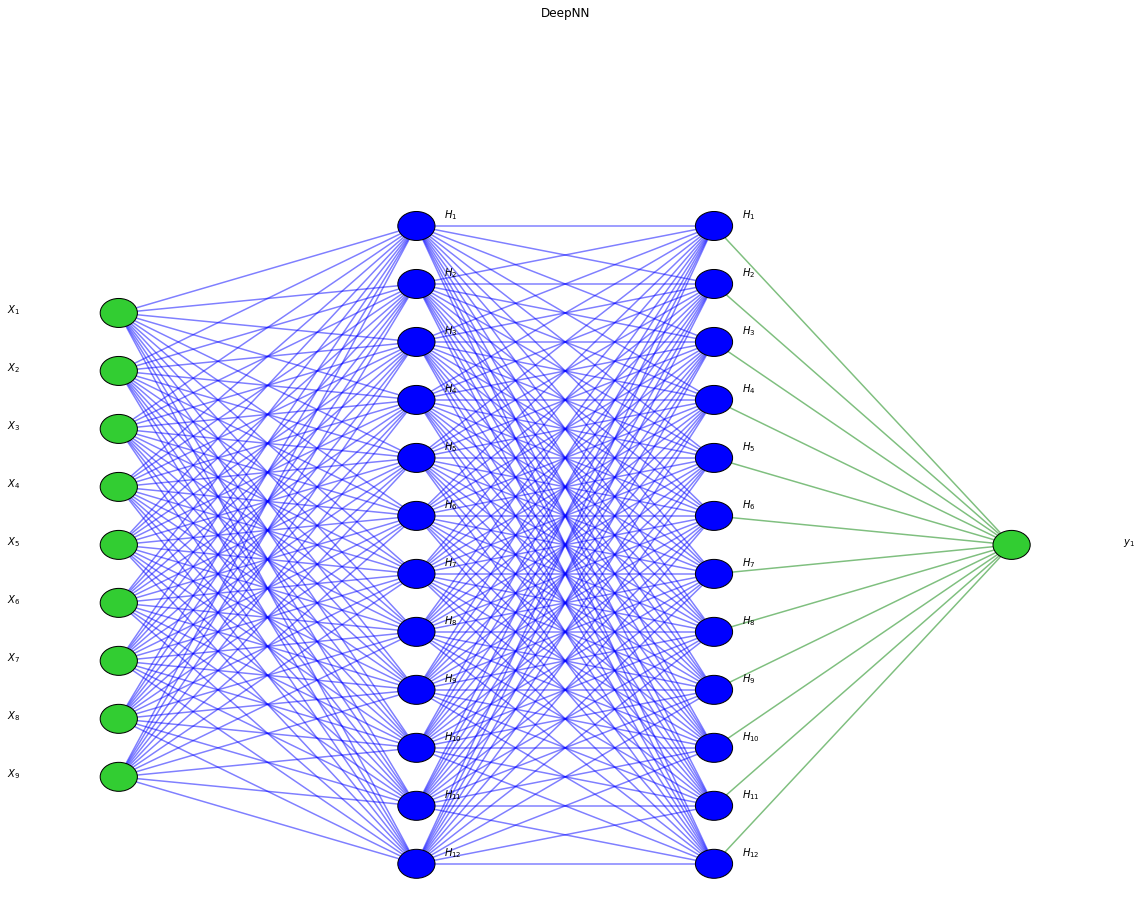

In [22]:
visualize_nn(model_for_plot, description=False, figsize=(20,16))

### Check the performance of the model

In [23]:
predicted_re = model.predict(X_test)

42/42 [==============================] - 1s 8ms/step


In [24]:
# get the original data before standardise
p2 = np.int32(scaler.inverse_transform(predicted_re))

In [25]:
# get the original data before standardise
y_test_t = np.int32(scaler.inverse_transform(y_test))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


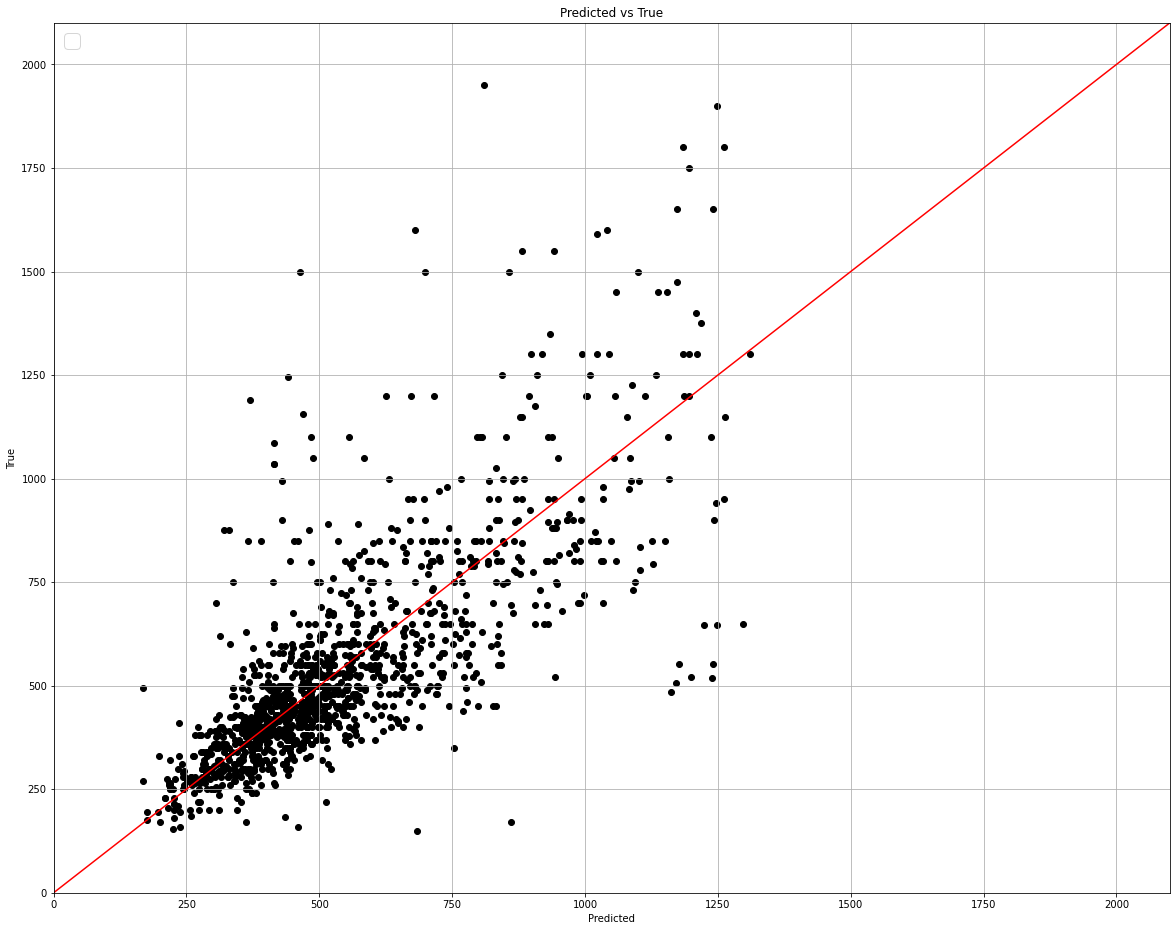

In [26]:
# plot a scatter plot with predicted value vs true value using testing dataset
fig, ax = plt.subplots(figsize=(20,16))
from statsmodels.graphics.api import abline_plot
ax.scatter(p2, y_test_t, color="black")
abline_plot(intercept=0, slope=1, color="red", ax=ax)
ax.grid(True)
ax.set(xlabel="Predicted", ylabel="True", title="Predicted vs True")
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
ax.legend()
plt.xlim(0,2100)
plt.ylim(0,2100)
plt.savefig('../plots/predicted.png')
plt.show()

### Predict the price of 2025

In [27]:
df2 = df1_4[['property_type', 'bedrooms', 'bathrooms', 'parking','schools', \
    'train_station(m)', 'CBD(m)', 'population2025', 'income2025']] #not significant property type, school, parking, distance to CBD

In [28]:
# one-hot encoding for the categorical feature
df_dummy = pd.get_dummies(df2['property_type'], \
    prefix=['property_type'], drop_first=False, dummy_na=False)
df2_1 = pd.concat([df2, df_dummy], axis=1)
df2_1 = df2_1.drop(['property_type'], axis = 1)

In [29]:
X_2025=df2_1.values

In [30]:
scaler = StandardScaler()
X_2025=scaler.fit_transform(X_2025)

In [31]:
y2 = df1_1[["cost_text"]].values
y2 = scaler.fit_transform(y2)

In [32]:
# predict the value
predicted_2025 = model.predict(X_2025)

207/207 [==============================] - 1s 7ms/step


In [33]:
# the final list of predicted price
predicted_2025_t = np.int32(scaler.inverse_transform(predicted_2025))
predicted_2025_t

array([[ 247],
       [ 345],
       [ 233],
       ...,
       [ 903],
       [ 554],
       [1120]], dtype=int32)

In [34]:
df1_4["predicted_2025"] = predicted_2025_t
df1_4

,index,Unnamed: 0,name,postcode,property_type,bedrooms,bathrooms,parking,schools,cost_text,...,population2022,population2023,population2024,population2025,income2022,income2023,income2024,income2025,price_label,predicted_2025
0,0,5321,Room 6/8 Melwood Court Meadow Heights VIC 3048,3048,Apartment / Unit / Flat,1,1,0,0.3,130.000000,...,17364.0,16549.0,15773.0,15034.0,86498,88316,90176,92078,0,247
1,1,5569,30 Daly Boulevard Highton VIC 3216,3216,House,9,2,2,2.0,130.000000,...,59229.0,60753.0,62377.0,64109.0,184195,192855,201927,211432,0,345
2,2,640,62 Reserve Rd Grovedale VIC 3216,3216,House,1,2,2,1.0,140.000000,...,59229.0,60753.0,62377.0,64109.0,184195,192855,201927,211432,0,233
3,3,5570,1/57 Wanda Road Caulfield North VIC 3161,3161,House,1,1,0,0.6,140.000000,...,10418.0,10185.0,9957.0,9734.0,56454,58176,59951,61780,0,346
4,4,5571,Room 2/31 Stanley Street Frankston VIC 3199,3199,House,1,1,1,1.1,145.000000,...,60500.0,59711.0,58932.0,58164.0,176387,182176,188161,194348,0,246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6676,6715,993,4203/35 Spring St Melbourne VIC 3004,3004,Apartment / Unit / Flat,3,2,4,1.4,1038.461538,...,8538.0,8166.0,7812.0,7473.0,82000,78618,76292,74826,3,1317
6677,6716,6157,3502/14-16 The Esplanade St Kilda VIC 3182,3182,Apartment / Unit / Flat,3,3,3,0.8,1153.846154,...,27813.0,26448.0,25151.0,23917.0,61492,63821,66238,68747,3,1206
6678,6717,6156,9 Lansdowne Street Blairgowrie VIC 3942,3942,House,3,2,3,3.3,1153.846154,...,2104.0,2128.0,2152.0,2177.0,44616,45495,46391,47305,3,903
6679,6718,6155,901 & 902/85 Market Street South Melbourne VIC...,3205,Apartment / Unit / Flat,3,3,1,0.3,1384.615385,...,3182.0,3085.0,2990.0,2899.0,70585,72357,74173,76035,3,554


In [35]:
#Calculate growth rate for each postcode

YEARS_CHANGE = 3
postcode_list = []
growth_rate_list = []

post_codes = df1_4.groupby("postcode")

for name, group in post_codes:
    #print(name)
    #print(group)
    mean_price = df1_4.groupby("postcode")["cost_text"].sum()[name]/df1_4.groupby("postcode")["cost_text"].count()[name]
    mean_predicted = df1_4.groupby("postcode")["predicted_2025"].sum()[name]/df1_4.groupby("postcode")["predicted_2025"].count()[name]
    price_change = mean_predicted - mean_price
    growth_rate = price_change/mean_price
    postcode_list.append(name)
    growth_rate_list.append(growth_rate)

In [36]:
#Create df showing postcode with highest growth rate
list_dict = {'post_code':postcode_list, 'growth_rate':growth_rate_list} 
growth_df = pd.DataFrame(list_dict) 
growth_df = growth_df.sort_values("growth_rate", ascending = False)
growth_df.head(n=10)


,post_code,growth_rate
154,3714,2.267857
160,3779,1.077143
11,3019,0.793766
61,3075,0.446740
18,3026,0.409205
37,3047,0.400249
12,3020,0.356444
38,3048,0.339016
49,3060,0.323021
29,3038,0.321212


In [37]:
#Saved normalised price
df1_4.to_csv('../data/curated/predicted_2025.1.csv')

In [38]:
#Saved growth rate for postcode
growth_df.to_csv('../data/curated/growth_rate3.csv', index=False) 